In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from model import Model
from simulation import FDTD_sim
from sources import *
from analysis import SimulationResultAnalyser, get_dB_response, get_frequency_response
from io_util import load_from_file, save_to_file

c:\Users\buijs\Documents\TUDelft\Masters Thesis\MEP_refactored\.venv\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


# Initialize and run simulation

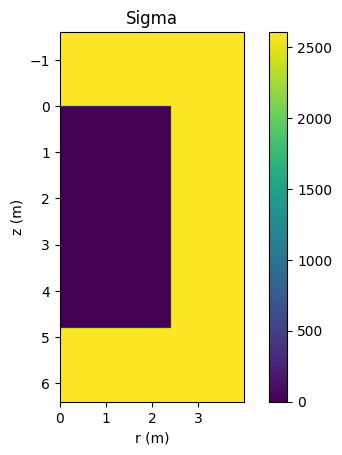

In [2]:
################################
# Create model                 #
################################

# Set model parameters
nr: int = 1000        # grid points in r
nz: int = 2000        # grid points in z
nt: int = 7000        # number of time steps
dr: float = 0.4e-2    # grid increment in r in (m)
dz: float = dr        # grid increment in z in (m) 
dt: float = 0.085e-5  # Time step size in (s)
c0: float = 1500.0    # speed of sound in (m/s)
beta: float = 3.5     # coefficient of nonlinearity  (3.5 for water)
rho0: float = 1e3     # density in (kg/m3)

# Diffusivity parameter
diffusivity: float = 0.007

model = Model(nr, nz, nt, dr, dz, dt, c0, beta, rho0, diffusivity)

# Set PML mask
width: int = 400
pml_mask = np.zeros((nr, nz))
pml_mask[nr-width:, :] = 1
pml_mask[:, :width] = 1
pml_mask[:, nz-width:] = 1

# Also possible to create PML regions within the domain
# pml_mask[nr//2-20:nr//2+20, nz//2-20:nz//2+20] = 1

# Set PML mask and calculate damping coefficient (sigma)
model.set_pml_mask(pml_mask, sigma_scaling=0, pml_width=width)

# Manually set damping coefficient. If reflections occur, increase this value.
# If the model is unstable, decrease this value.
model.sigma *= 10/width/1.8

# Plot model
model.plot(axis_label="space")

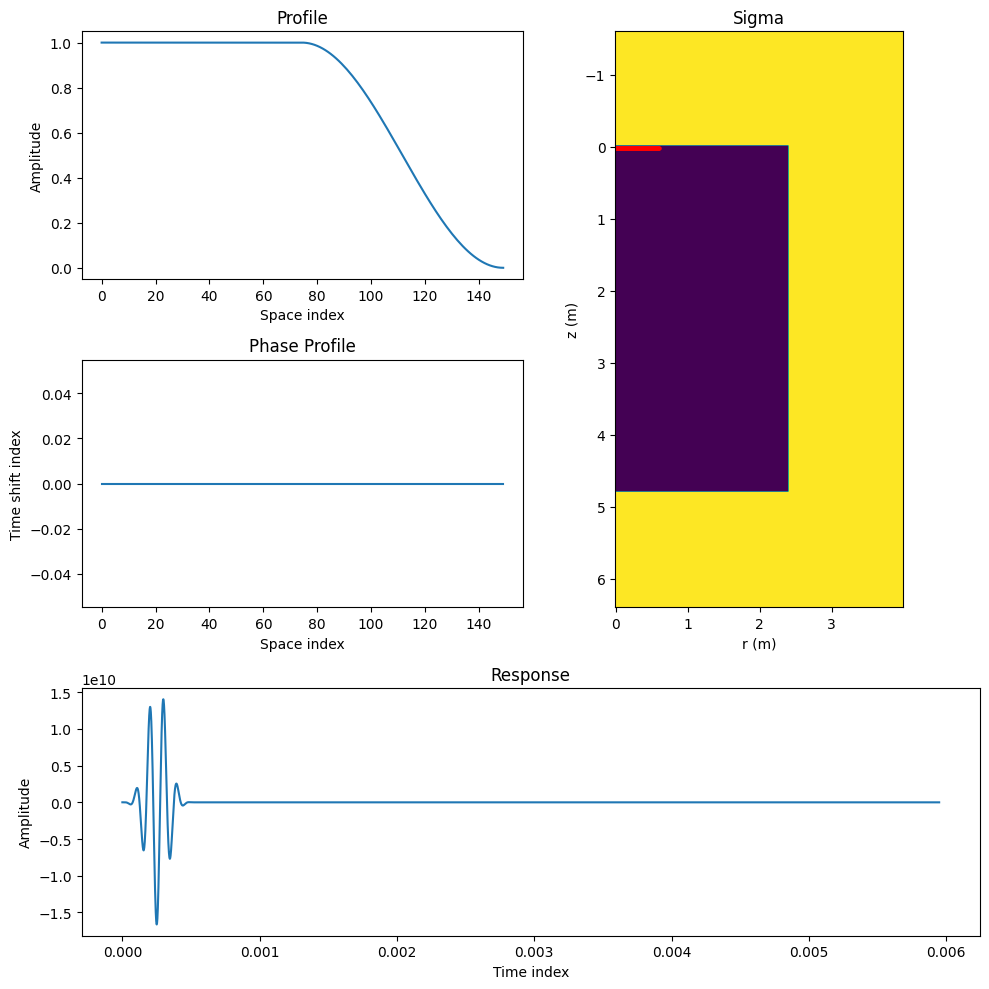

In [8]:
################################
# Create source                #
################################

# Set source parameters
source_width: int = int(0.6 / dr)
isr: int = 0        # source index r
isz: int = width+5  # source index z
ist: int = 0        # shifting of source time function
pulse_length: int = 600  # length of the pulse in number of time steps
amplitude: float = 10e5  # Source amplitude. Does not correspond 1 to 1 with the amplitude of generated wave.

f0: float = 10e3        # center frequency of source (Hz)
delta_f: float = 3e3    # Difference frequency for parametric source

# Create source
# source = ParametricSource(isr, isz, source_width, amplitude, f0-delta_f/2, f0+delta_f/2, nt, dt, dr, dz, ist, pulse_length)
source = CosineSource(isr, isz, source_width, amplitude, f0, nt, dt, dr, dz, ist, pulse_length)

# source.set_focus(20, 0, 30, c0)

# Plot source information, including spatial window, phase profile due to 
# focussing, location in the domain, and pulse response
source.plot_info(model=model)


In [9]:
################################
# Run simulation               #
################################

# Initialise simulation
sim = FDTD_sim(model=model, subsample_space=2, subsample_time=2)
sim.add_source(source)

# Run simulation
result = sim.run_simulation_cuda(type="nonlinear")

100%|██████████| 7000/7000 [01:08<00:00, 102.02it/s]


In [10]:
###################################
# Load SimulationResult from file #
###################################

result_loaded = load_from_file()
if result_loaded is not None:
    result = result_loaded
    
    if result.sources[0].__class__.__name__ == "ParametricSource":
        delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
    
print(result.model)

print(f"Size of result.p: {result.p.nbytes/1e6:.2f} MB")
# del result

No file selected. Exiting...
Model:
  nr=1000
  nz=2000
  dr=0.004 m
  dz=0.004 m
  nt=7000
  dt=8.5e-07 s
  domain_r=2.392 m
  domain_z=4.8 m
  pml_width=400 / 1.6 m
Size of result.p: 2512.32 MB


# Analyse simulation result

In [11]:
###################################
# Initialize analyser object      #
###################################

analyser = SimulationResultAnalyser(result)

1119163.4


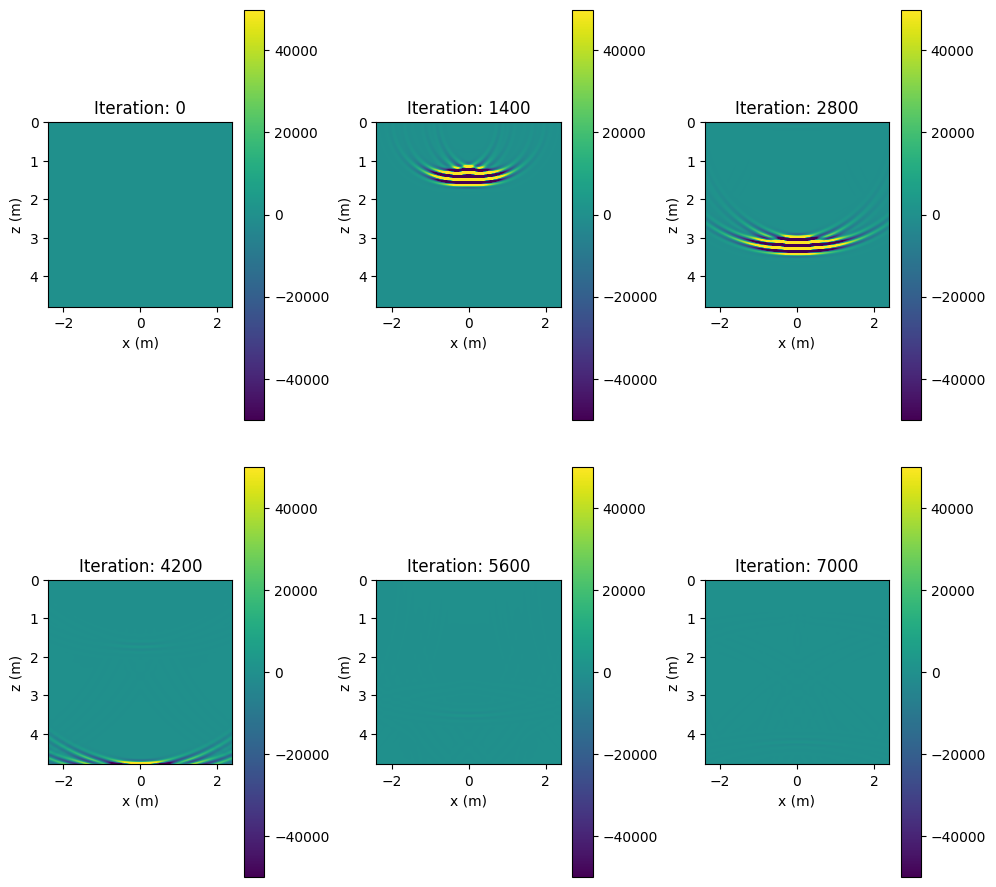

In [12]:
################################################
# Plot pressure field at 6 different timesteps #
################################################

print(result.p.max())
vlimit = result.sources[0].amplitude*1/4/5

analyser.plot_snapshots(vlimit=vlimit, mirror=True, title_type="iteration")

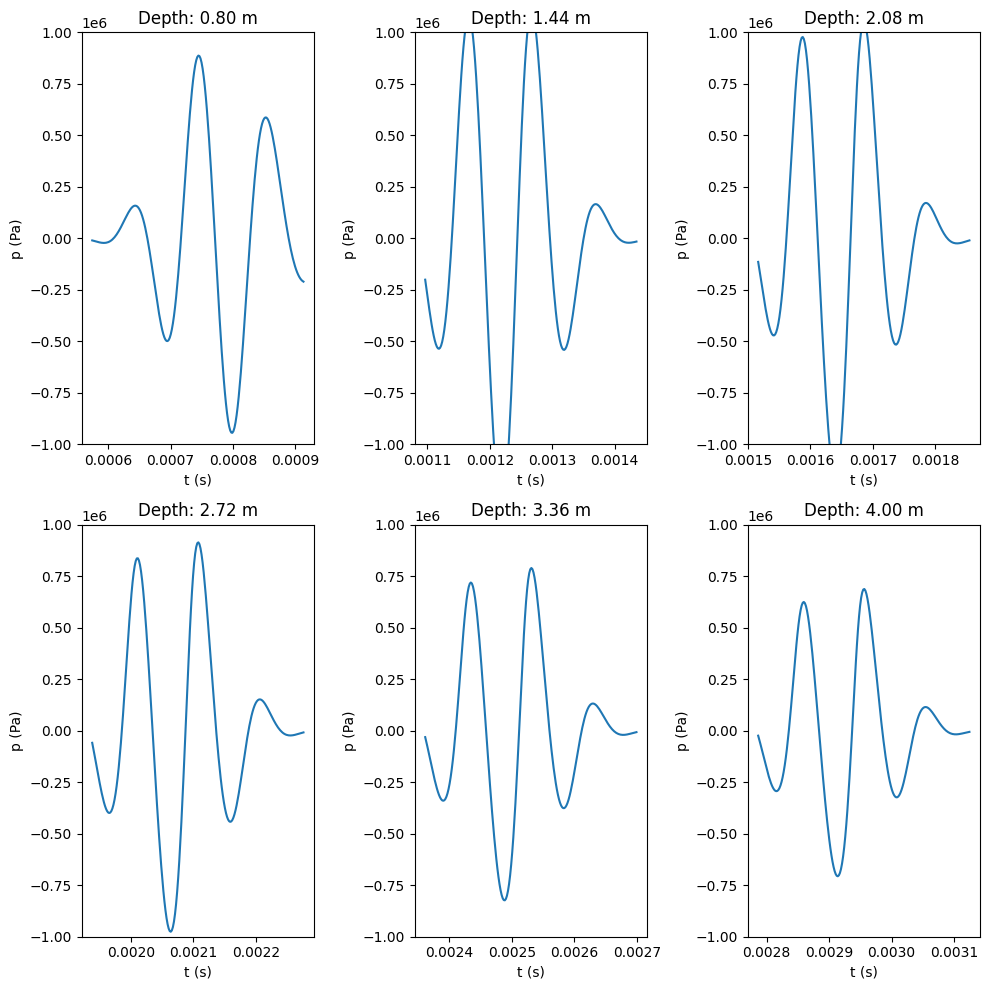

In [13]:
#############################################
# Plot pulse measured at 6 different depths #
#############################################

analyser.plot_slices_time(window_size=100, vlimit=1e6)

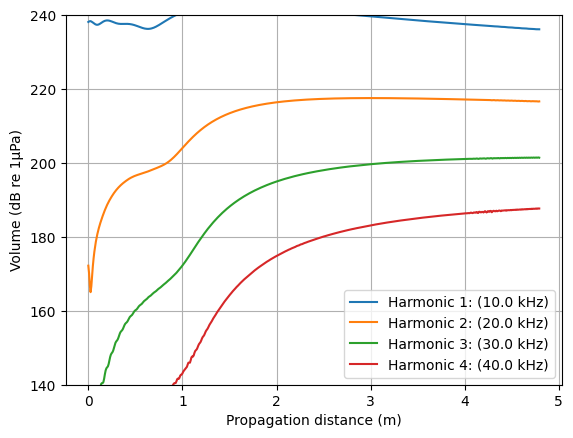

In [14]:
###################################
# Plot harmonic progression       #
###################################

if result.sources[0].__class__.__name__ == "ParametricSource":
    include_subharmonic = True
    delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
else:
    include_subharmonic = False

# Calculate harmonic progression
distances, harmonic_progression_array, harmonics = analyser.harmonic_progression(num_harmonics=4,
                                                         r_start=0,
                                                         z_start=0,
                                                         angle=0,
                                                         include_subharmonic=include_subharmonic,
                                                         subharmonic_freq=delta_f,
                                                         scaling_factor = result.sources[0].scaling_factor*result.subsample_time,
                                                         normalize=False)

# Plot harmonic progression
if include_subharmonic:
    plt.plot(distances, harmonic_progression_array[0], label=f"Subharmonic: ({delta_f/1e3} kHz)")
    for i in range(1, harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i}: ({harmonics[i]/1e3} kHz)")
else:
    for i in range(harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i+1}: ({harmonics[i]/1e3} kHz)")


# Set plot parameters
plt.xlabel("Propagation distance (m)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")
plt.ylim(140, 240)
plt.grid()
# plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.legend(loc="lower right")
plt.show()

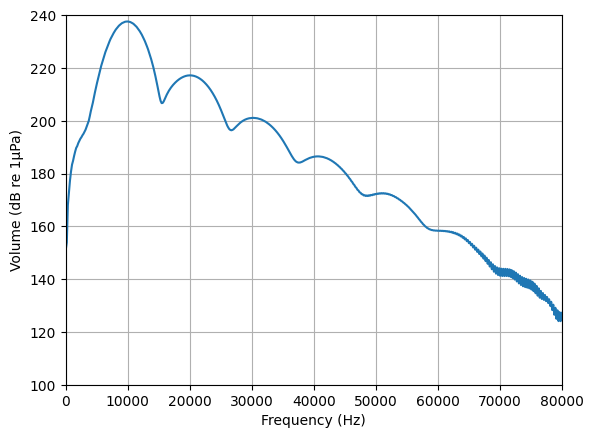

In [18]:
##############################################
# Plot frequency response at specified depth #
##############################################

depth = 4  # m
ymin = 100
ymax = 240

r_index = 0
z_index = int(depth/dz/result.subsample_space)

plt.plot(*get_dB_response(np.pad(result.p[:, r_index, z_index], (0,0)), 
                          result.model.dt*result.subsample_time, 
                          result.sources[0].scaling_factor*result.subsample_time, 
                          normalize=False))

plt.xlabel("Frequency (Hz)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")
# plt.xlim(0,4*result.sources[0].frequency1)
# plt.xlim(0,5.5*result.sources[0].frequency1)
plt.xlim(0,80000)
plt.ylim(ymin,ymax)
# plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.grid()
plt.show()

In [22]:
###################################
# Generate GIF                    #
###################################

analyser.generate_gif("images/gifs/test_mirrored.gif", fps=30, frame_interval=20, vlimit=vlimit*10, mirror=True)

In [11]:
###################################
# Compute beam profile            #
###################################

frequencies, lobes_array = analyser.get_lobes_all(scaling_factor=result.sources[0].scaling_factor, subsample_space=1)
# frequencies, lobes_array = result.get_lobes_all_split(scaling_factor=result.sources[0].scaling_factor, subsample_space=3)

Array too large for GPU. Setting subsample to 3.


 91%|█████████▏| 32/35 [00:14<00:00, 37.15it/s]

Text(0, 0.5, 'z (m)')

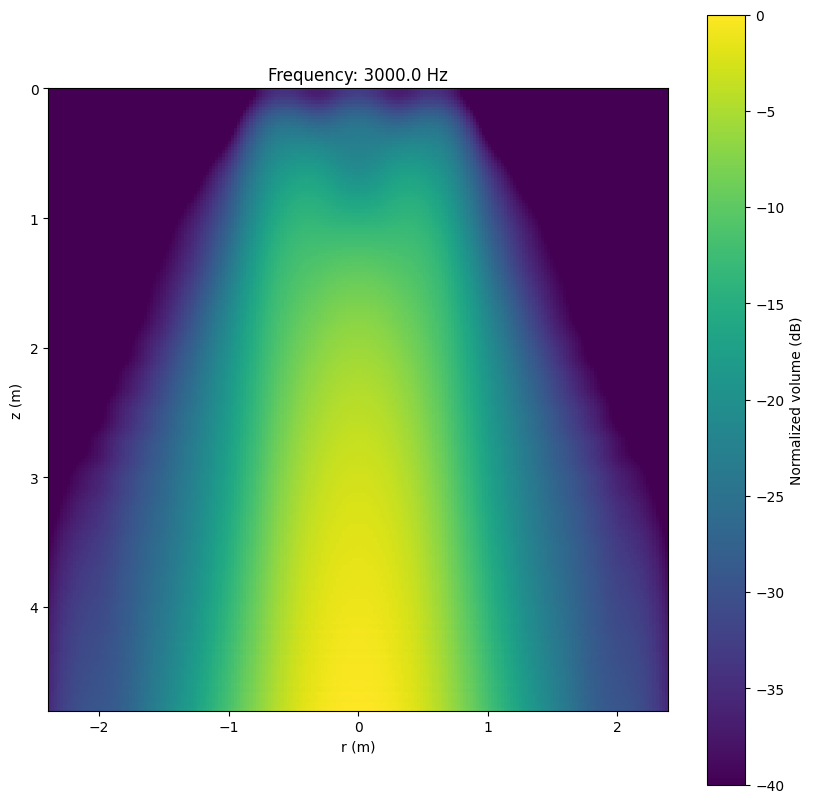

In [16]:
###########################
# Plot beam profile       #
###########################

freq_to_plot = delta_f
# freq_to_plot = 1*result.sources[0].frequency1

normalized = True
vmin = -40
vmax = 0

# Select frequency to plot
idx = np.argmin(np.abs(frequencies - freq_to_plot))
lobes_selection = lobes_array[idx]

# Compute dB values
lobes_selection = 20*np.log10(lobes_selection/1e-6)
if normalized:
    lobes_selection -= lobes_selection.max()

# Mirror over z-axis
lobes_selection_mirrored = np.concatenate([np.flip(lobes_selection, axis=0), lobes_selection], axis=0)

# Plot
fig = plt.figure(figsize=(10, 10))
plt.imshow(lobes_selection_mirrored.T, 
           extent=[-result.model.nrd * result.model.dr, result.model.nrd * result.model.dr, result.model.nzd * result.model.dz, 0], 
           vmin=vmin, vmax=vmax)

cbar = plt.colorbar()
if normalized:
    cbar.set_label("Normalized volume (dB)")
else:
    cbar.set_label("Volume (dB re 1\u00B5Pa)")

plt.title(f"Frequency: {freq_to_plot} Hz")
plt.xlabel("r (m)")
plt.ylabel("z (m)")

In [6]:
###################################
# Save SimulationResult to file   #
###################################

save_to_file(result)